In [2]:
import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/miru/sr-press


In [3]:
from socceraction.data.statsbomb import StatsBombLoader
from statsbombpy import sb
from express.databases import SQLiteDatabase
from express.visualization import plot_action
from express.utils import add_names

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
SBL = StatsBombLoader(root=os.path.join(base_path, "open-data/data"), getter="remote")
competition = sb.competitions()

# HTTPError: 404 Client Error: Not Found for ur
Error_competition = [(11, 90), (7, 235), (7, 108), (44, 107)] # La-Liga 20/21, Ligue1 21/22, Ligue1 22/23 
competition = competition[~competition[["competition_id", "season_id"]].apply(tuple, axis=1).isin(Error_competition)] # HTTPError: 404 Client Error: Not Found for ur
competition = competition[(competition["match_available_360"].notna()) & (competition["competition_gender"] == "male")]
competition

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
29,43,106,International,FIFA World Cup,male,False,True,2022,2024-05-15T10:23:32.854925,2024-06-11T11:30:50.462448,2024-06-11T11:30:50.462448,2024-05-15T10:23:32.854925
68,55,282,Europe,UEFA Euro,male,False,True,2024,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,2024-07-15T15:52:24.778809,2024-07-15T15:48:50.315500
69,55,43,Europe,UEFA Euro,male,False,True,2020,2024-04-16T12:44:40.558402,2024-04-16T12:47:18.505110,2024-04-16T12:47:18.505110,2024-04-16T12:44:40.558402


In [5]:
train_competition = competition[~(competition["competition_name"] == "FIFA World Cup")]
test_competition = competition[(competition["competition_name"] == "FIFA World Cup")]

print(train_competition.shape, test_competition.shape)

(3, 12) (1, 12)


In [6]:
train_games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in train_competition.itertuples()
]).reset_index(drop=True)

test_games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in test_competition.itertuples()
]).reset_index(drop=True)

print(train_games.shape, test_games.shape)
train_games

FileNotFoundError: [Errno 2] No such file or directory: '/home/miru/sr-press/open-data/data/matches/9/281.json'

In [8]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f29c153bd00>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f29c15b2790>


In [7]:
TRAIN_DB_1_PATH = os.path.join(base_path, "stores/train_database (1).sqlite")
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")

TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db_1= SQLiteDatabase(TRAIN_DB_1_PATH)
train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db_1:", train_db_1)
print("train_db:", train_db)
print("test_db:", test_db)

train_db_1: <express.databases.sqlite.SQLiteDatabase object at 0x7fb0c7065520>
train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7fb16de5fb80>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7fb4406c7e80>


In [35]:
for _, game in tqdm(train_games.iterrows(), desc="train_game loading"):
    dataset = {"getter": "local", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"],
                "root": os.path.join(base_path, "open-data/data")}
    
    train_db.import_data(**dataset)

for _, game in tqdm(test_games.iterrows(), desc="test_game loading"):
    dataset = {"getter": "local", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"],
                "root": os.path.join(base_path, "open-data/data")}
    
    test_db.import_data(**dataset)

train_game loading: 0it [00:00, ?it/s]

test_game loading: 0it [00:00, ?it/s]

In [8]:
train_db.games()

,season_id,competition_id,game_day,game_date,home_team_id,away_team_id,competition_stage,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
3788741,43,55,1,2021-06-11 21:00:00,909,914,Group Stage,0,3,Estadio Olímpico,Danny Desmond Makkelie
3788742,43,55,1,2021-06-12 18:00:00,776,1835,Group Stage,0,1,Parken,Anthony Taylor
3788743,43,55,1,2021-06-12 21:00:00,782,796,Group Stage,3,0,Saint-Petersburg Stadium,Antonio Miguel Mateu Lahoz
3788744,43,55,1,2021-06-12 15:00:00,907,773,Group Stage,1,1,Bakı Olimpiya Stadionu,Clément Turpin
3788745,43,55,1,2021-06-13 15:00:00,768,785,Group Stage,1,0,Wembley Stadium,Daniele Orsato
...,...,...,...,...,...,...,...,...,...,...,...
3942349,282,55,5,2024-07-05 22:00:00,780,771,Quarter-finals,0,0,Volksparkstadion,Michael Oliver
3942382,282,55,5,2024-07-06 22:00:00,941,909,Quarter-finals,2,1,Olympiastadion Berlin,Clément Turpin
3942752,282,55,6,2024-07-09 22:00:00,772,771,Semi-finals,2,1,Allianz Arena,Slavko Vinčić


In [21]:
train_db.actions(3788745)['freeze_frame_360']

game_id  action_id
3788745  0            [{'teammate': True, 'actor': False, 'keeper': ...
         1            [{'teammate': True, 'actor': False, 'keeper': ...
         2            [{'teammate': True, 'actor': True, 'keeper': F...
         3            [{'teammate': True, 'actor': False, 'keeper': ...
         4            [{'teammate': True, 'actor': False, 'keeper': ...
                                            ...                        
         2358         [{'teammate': True, 'actor': True, 'keeper': F...
         2359         [{'teammate': True, 'actor': False, 'keeper': ...
         2360         [{'teammate': True, 'actor': False, 'keeper': ...
         2361         [{'teammate': True, 'actor': False, 'keeper': ...
         2362         [{'teammate': True, 'actor': False, 'keeper': ...
Name: freeze_frame_360, Length: 2363, dtype: object

In [22]:
train_db_1.actions(3788745)['freeze_frame_360']

game_id  action_id
3788745  0            [{'teammate': True, 'actor': False, 'keeper': ...
         1            [{'teammate': True, 'actor': False, 'keeper': ...
         2            [{'teammate': True, 'actor': True, 'keeper': F...
         3            [{'teammate': True, 'actor': False, 'keeper': ...
         4            [{'teammate': True, 'actor': False, 'keeper': ...
                                            ...                        
         2245         [{'teammate': True, 'actor': True, 'keeper': F...
         2246         [{'teammate': True, 'actor': False, 'keeper': ...
         2247         [{'teammate': True, 'actor': False, 'keeper': ...
         2248         [{'teammate': True, 'actor': False, 'keeper': ...
         2249         [{'teammate': True, 'actor': False, 'keeper': ...
Name: freeze_frame_360, Length: 2250, dtype: object

In [8]:
game_id = 3895202

df_actions = add_names(test_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3895202,0,b98b3109-8cb2-4017-8960-a8cb2a1937c1,1,0.575,182,39167,52.0625,34.425,49.2625,...,From Kick Off,0,0.440712,"{'pass': {'recipient': {'id': 16532, 'name': '...",None,0,None,pass,success,foot_left
1,3895202,1,c2231776-f3ce-43d6-b431-0af2dc65c313,1,1.016,182,16532,49.2625,31.875,48.5625,...,From Kick Off,0,0.120000,"{'carry': {'end_location': [56.0, 43.0]}}",None,0,None,dribble,success,foot
2,3895202,2,04aea3ae-64dc-4ec8-aca8-96f72f4ffa44,1,1.136,182,16532,48.5625,31.875,51.7125,...,From Kick Off,0,0.582041,"{'pass': {'recipient': {'id': 39167, 'name': '...",None,0,None,pass,success,foot_right
3,3895202,3,e8417cec-49aa-4d9f-89ee-b6fca968081d,1,1.718,182,39167,51.7125,34.000,51.1000,...,From Kick Off,0,0.160000,"{'carry': {'end_location': [58.9, 40.5]}}",None,0,None,dribble,success,foot
4,3895202,4,c10715ad-d07f-4a7e-afa1-591d47148016,1,1.878,182,39167,51.1000,34.000,40.6875,...,From Kick Off,0,0.863635,"{'pass': {'recipient': {'id': 39460, 'name': '...",None,0,None,pass,success,foot_right


In [13]:
df_actions[df_actions["original_event_id"] == "c2d74b65-f31d-4d50-a027-fb42fec6ac60"].iloc[:, :13]

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id
555,3895202,555,c2d74b65-f31d-4d50-a027-fb42fec6ac60,1,973.716,182,39460,53.1125,34.51,53.1125,34.51,0,23


In [14]:
df_actions[df_actions["original_event_id"] == "c2d74b65-f31d-4d50-a027-fb42fec6ac60"].iloc[:, 13:]

,result_id,possession_team_id,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
555,0,904.0,From Free Kick,0,0.321153,{},"[[45.70343873800862, 12.94260716187194], [39.3...",1,"[{'teammate': False, 'actor': False, 'keeper':...",pressing,fail,foot


In [25]:
df_actions[(df_actions["type_name"] == "pressing") & (df_actions["result_name"] == "success")]

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
24,3895202,24,3f8d14ac-59bf-4cbe-b120-102158d1ef35,1,25.559,182,39460,24.4125,19.125,24.4125,...,From Kick Off,0,0.562128,{},"[[24.57646051263199, 0.0], [0.0, 34.4578136224...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,success,foot
64,3895202,64,4f399b93-6615-4cfb-960d-9b764bfa1776,1,77.861,182,16532,54.1625,58.735,54.1625,...,Regular Play,0,0.434901,{},"[[42.68190939060328, 18.895501662363557], [32....",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,success,foot
69,3895202,69,78cf8e89-ac05-43ee-b821-f33db333654a,1,79.123,182,16532,56.8750,61.030,56.8750,...,Regular Play,0,0.323607,{},None,0,None,pressing,success,foot
102,3895202,102,7f5d4975-73ad-4d70-9b6a-f8db7129951b,1,130.211,182,39167,86.8875,48.110,86.8875,...,Regular Play,0,0.579930,{},"[[84.03842907277306, 9.447872880374042], [65.3...",1,"[{'teammate': False, 'actor': False, 'keeper':...",pressing,success,foot
115,3895202,115,8b054676-0daf-42f3-a696-11d9ec8fce71,1,136.363,904,40724,84.7875,53.550,84.7875,...,Regular Play,0,0.191365,{},"[[105.0, 68.0], [105.0, 52.21212965398104], [8...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,success,foot
121,3895202,121,adcc82d8-ea4a-4380-ad51-310daec3a3c3,1,138.273,904,3500,82.5125,48.110,82.5125,...,Regular Play,0,0.537864,{},"[[105.0, 68.0], [105.0, 57.565562276421666], [...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,success,foot
124,3895202,124,1ffd9aae-852d-45f7-a9a7-260a29c4116a,1,138.872,904,40724,79.4500,48.195,79.4500,...,Regular Play,0,0.962961,{},"[[105.0, 68.0], [105.0, 59.28230373252102], [7...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,success,foot
127,3895202,127,a944268b-8828-4c8a-8486-63ee8c1051d8,1,142.058,182,39460,77.9625,54.145,77.9625,...,Regular Play,0,0.324438,{},"[[80.07880191620546, 17.48525232598847], [60.7...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,success,foot
146,3895202,146,d347dc72-51dd-4b63-878f-c189b7231f9b,1,160.118,182,8507,22.4875,43.520,22.4875,...,Regular Play,0,0.445501,{},"[[24.88058001544788, 11.069671537506466], [0.0...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,success,foot
155,3895202,155,655c232e-f170-49ad-8fde-87d75bcda984,1,166.654,904,10336,11.2875,17.850,11.2875,...,Regular Play,0,0.332426,{},"[[14.625090616504437, 68.0], [34.3006394727186...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,success,foot


In [19]:
df_actions[df_actions["type_name"] == "pressing"].index[62]

555

909 914


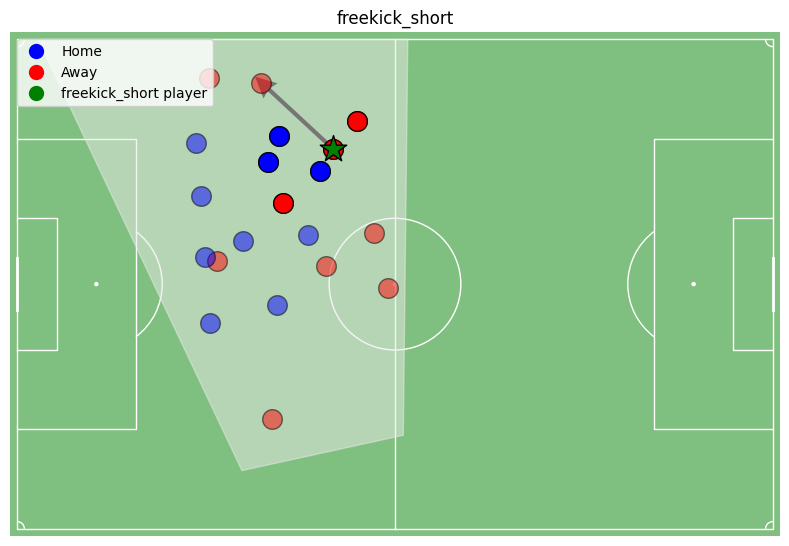

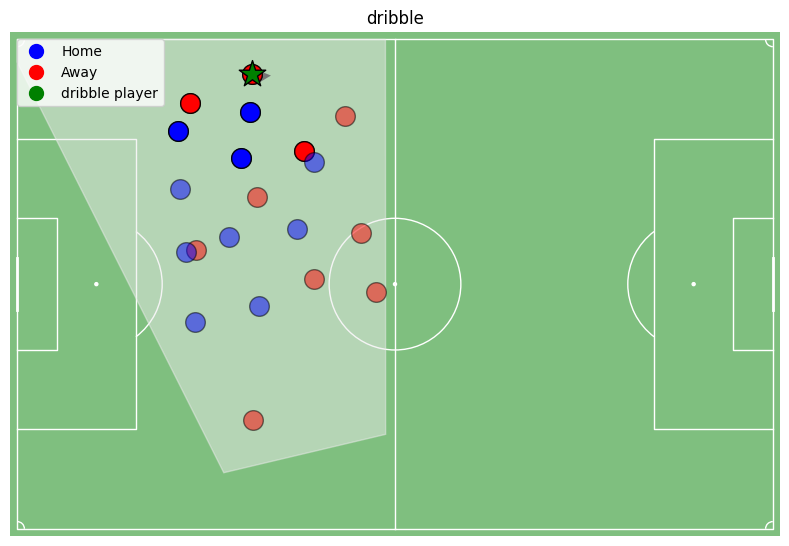

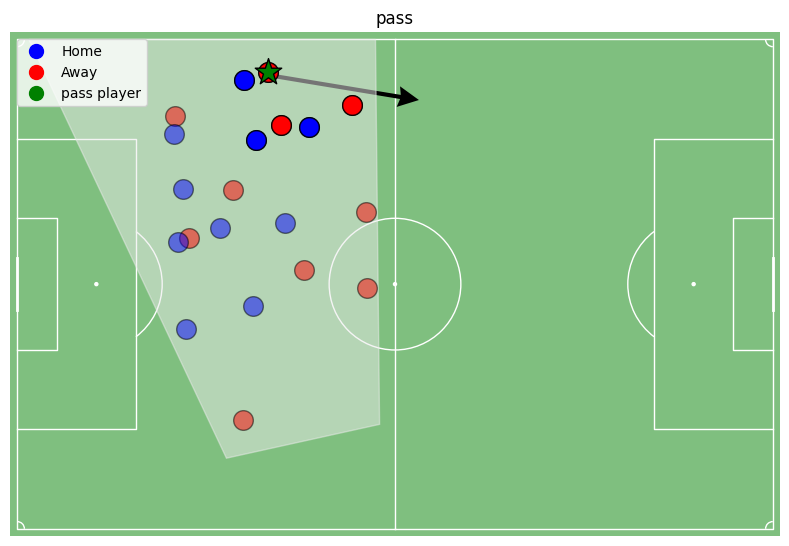

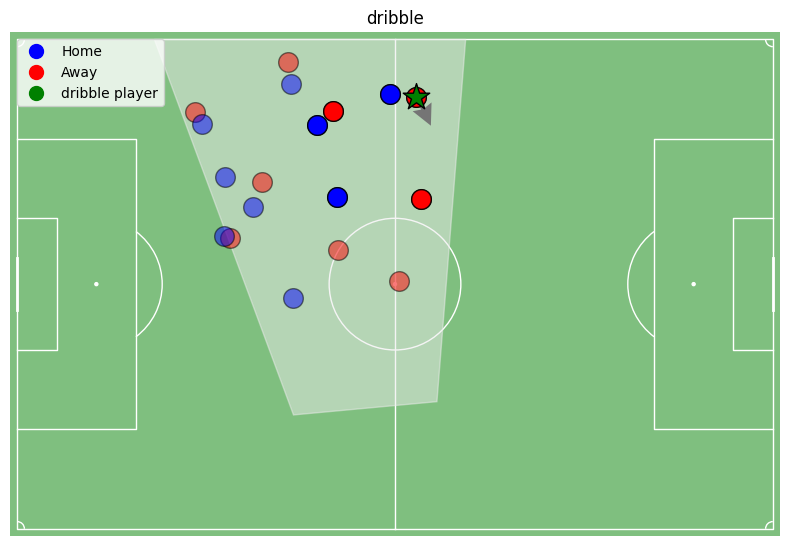

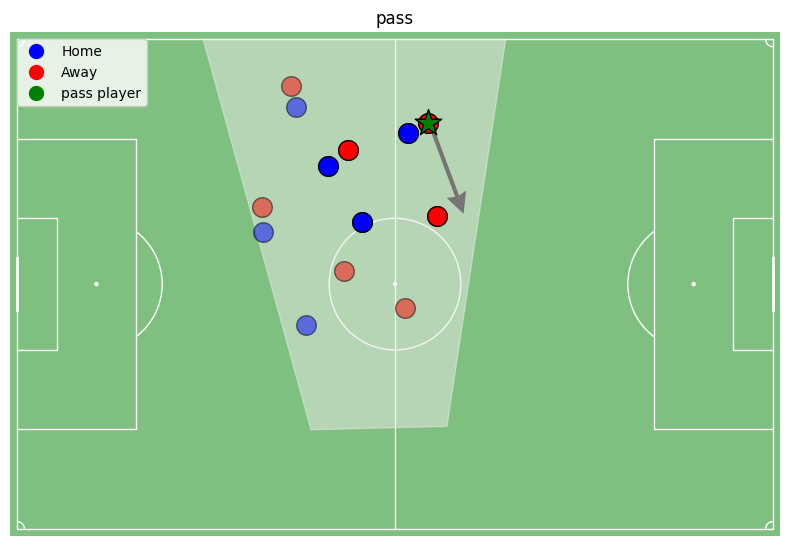

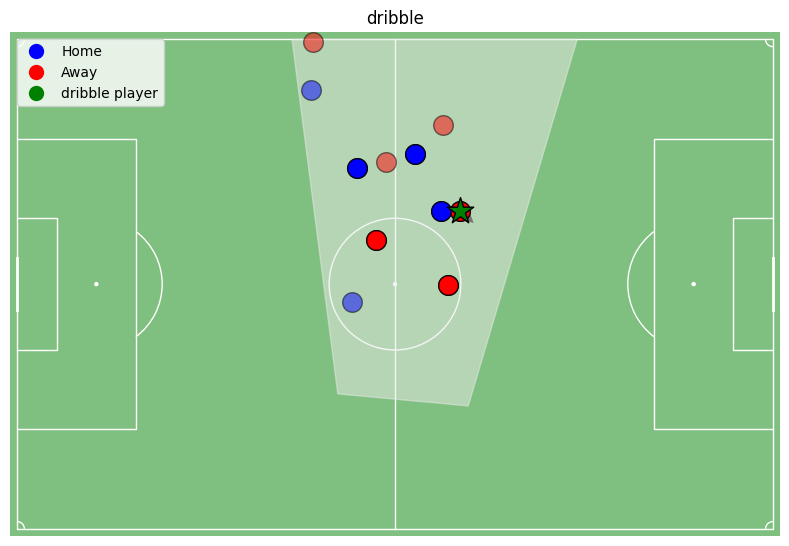

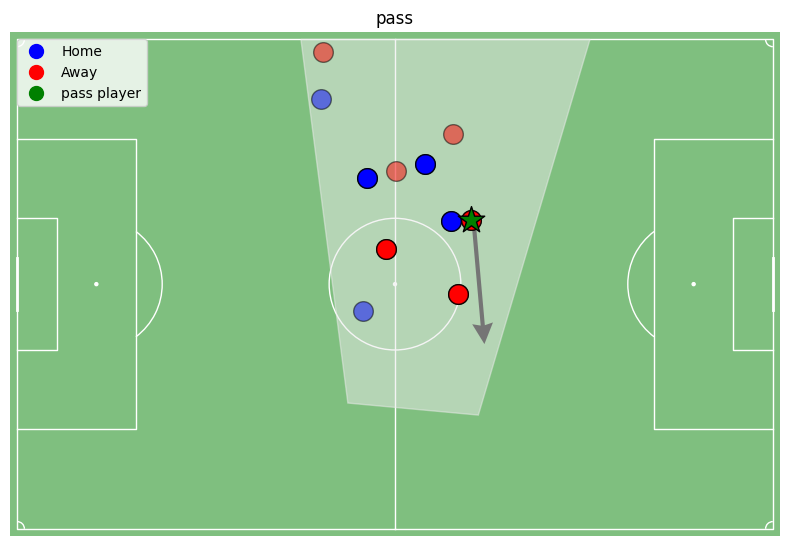

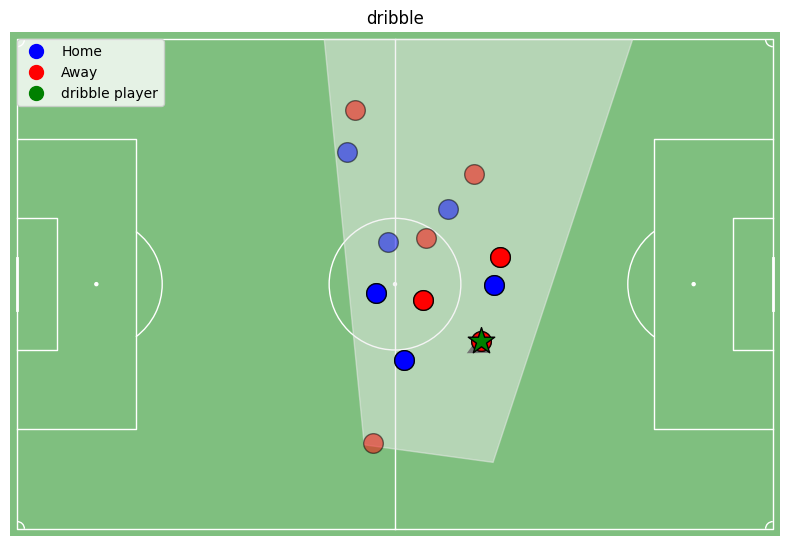

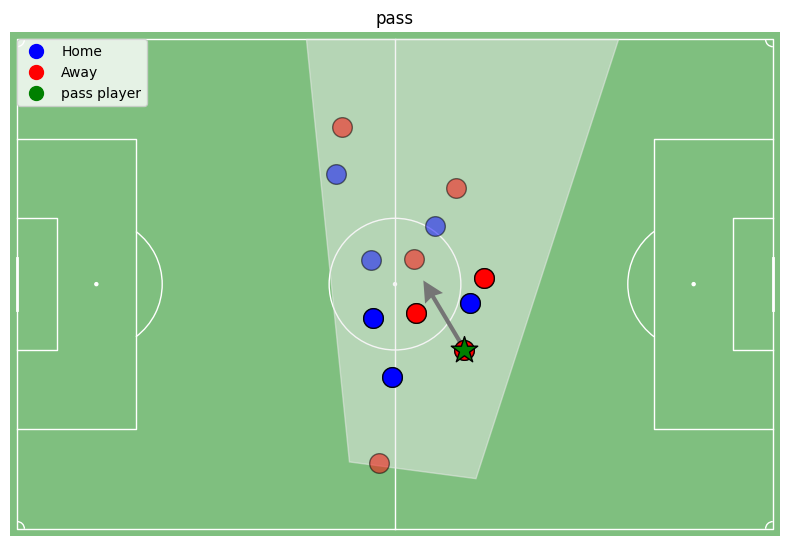

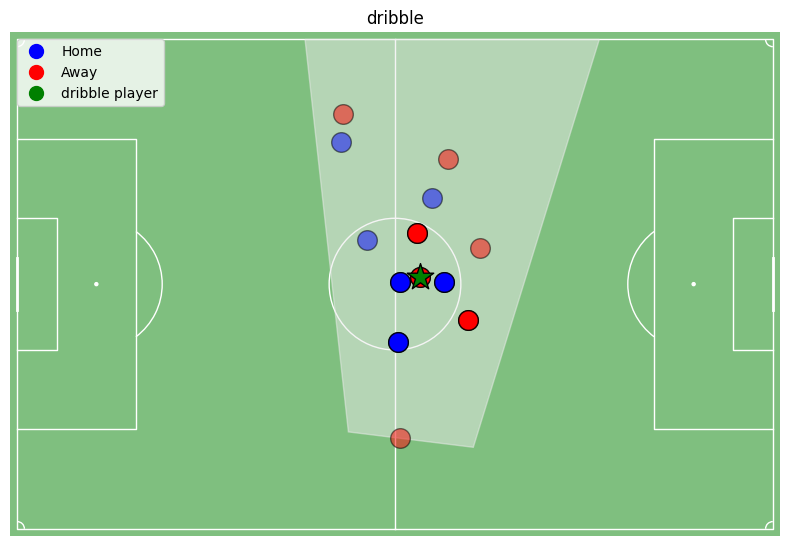

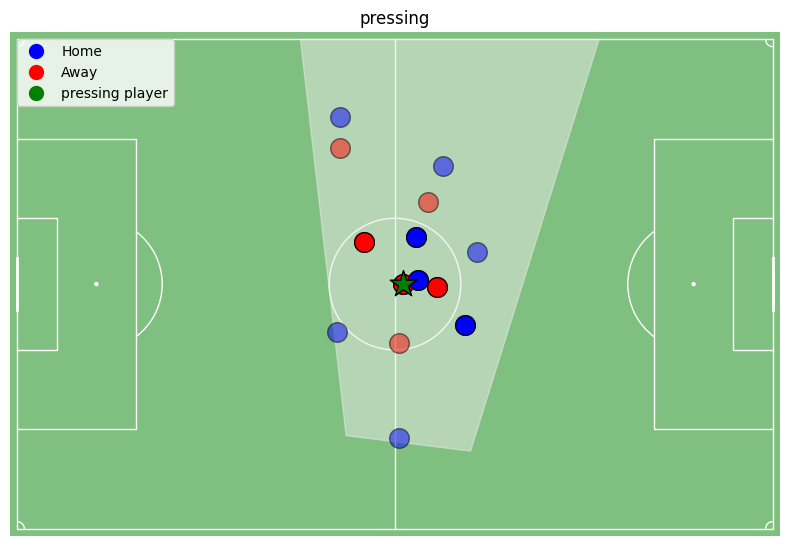

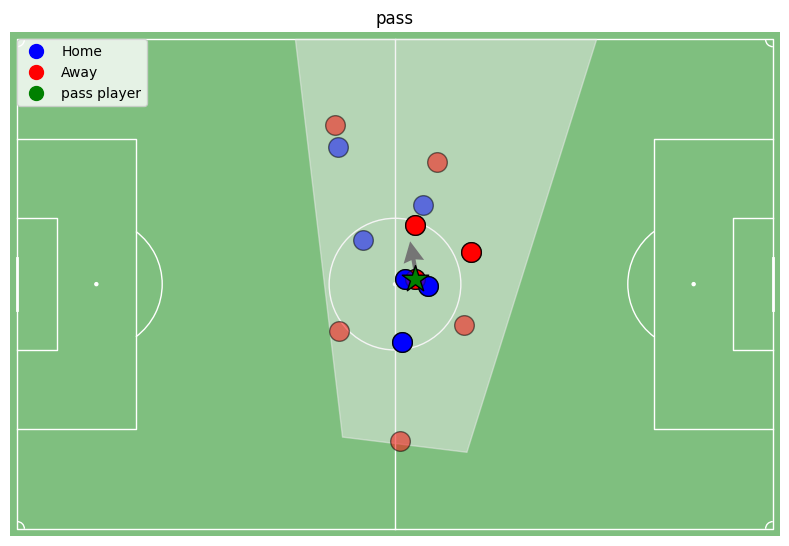

In [22]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[62]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3788741)

print(home_team_id, away_team_id)

for idx in range(pressure_idx-10, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame:",idx)
        plot_action(df_actions.loc[idx], home_team_id=home_team_id, show_visible_area=False)
    else:
        # plot_action: 데이터의 위치 정보는 홈팀은 left->right, 원정팀은 left<-right인 상태이다.
        plot_action(df_actions.loc[idx], home_team_id=home_team_id)